# Linking it all together

I will link the Kuramoto oscillators group with a HH group of neurons. This mixes the examples tried so far to make sure the linked variables work as expected.

In [1]:
from brian2 import *

INFO       Cache size for target "cython": 13525 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/nikos/.cython/brian_extensions" directory. [brian2]


In [2]:
# Kuramoto oscillators
kuramoto_eqs_stim = '''
    dTheta/dt = ((omega + (kN * PIF) - I_stim*X*sin(Theta)) * second**-1) : 1
    PIF = .5 * (sin(ThetaPreInput - Theta)) : 1
    Vm = sin(Theta)*mV : volt
    ThetaPreInput : 1
    omega : 1
    kN : 1
    I_stim : amp
    X = pulse_train(t) : amp**-1
'''

# synapses
syn_kuramoto_eqs = '''
    ThetaPreInput_post = Theta_pre
'''

# Order parameter calculation equations
pop_avg_eqs = '''
    x : 1
    y : 1
    coherence = sqrt(x**2 + y**2) : 1
    phase = arctan(y/x) + int(x<0 and y>0)*pi - int(x<0 and y<0)*pi: 1
    rhythm = coherence * sin(phase) : 1
    rhythm_test = coherence * (sin(phase)+1)/2 : 1
    rhythm_simple = rhythm*nA : amp
    rhythm_abs = abs(rhythm)*nA : amp
    rhythm_rect = rhythm_test*nA : amp
'''

syn_avg_eqs = '''
    x_post = cos(Theta_pre)/N_incoming : 1 (summed)
    y_post = sin(Theta_pre)/N_incoming : 1 (summed)
'''

In [3]:
# Parameters
duration = 1*second

# Oscillators
seed(42)
N = 50
f0 = 4 # center freq [Hz]
sigma = 0.5 # normal std

# Inputs setup
dt_stim = 1*ms
I0 = 15*amp
tv = linspace(0, duration/second, int(duration/(dt_stim))+1)
xstim = 1. * logical_and(tv>0.75, tv<0.76)
pulse_train = TimedArray(xstim*amp**-1, dt=dt_stim)

In [4]:
# Kuramoto oscillators group
net_kur = Network()
oscillators = NeuronGroup(N, kuramoto_eqs_stim, threshold='True', method='euler', name='Kuramoto_N_%d' %N)
oscillators.Theta = '2*pi*rand()' # uniform U~[0,2π]
oscillators.omega = '2*pi*(f0+sigma*randn())' # normal N~(f0,σ)
oscillators.kN = 10
oscillators.I_stim = I0
osc_synapses = Synapses(oscillators, oscillators, on_pre=syn_kuramoto_eqs)
osc_synapses.connect(condition='i!=j')

# mean phase output
population = NeuronGroup(1, pop_avg_eqs)
r0 = 1/N * sum(exp(1j*oscillators.Theta))
population.x = real(r0)  # avoid division by zero
population.y = imag(r0)
average = Synapses(oscillators, population, syn_avg_eqs)
average.connect()

# monitors
mon_osc = StateMonitor(oscillators, 'Theta', True)
mon_avg = StateMonitor(population, ['coherence', 'phase', 'rhythm'], record=True)

# add all of the above to the network
net_kur.add(oscillators)
net_kur.add(population)
net_kur.add(average)
net_kur.add(mon_osc)
net_kur.add(mon_avg)
net_kur.add(osc_synapses)

# run the simulation
net_kur.run(duration, report='text', report_period=10*second, profile=True)
print("Simulation done")

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]


Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in < 1s
Simulation done


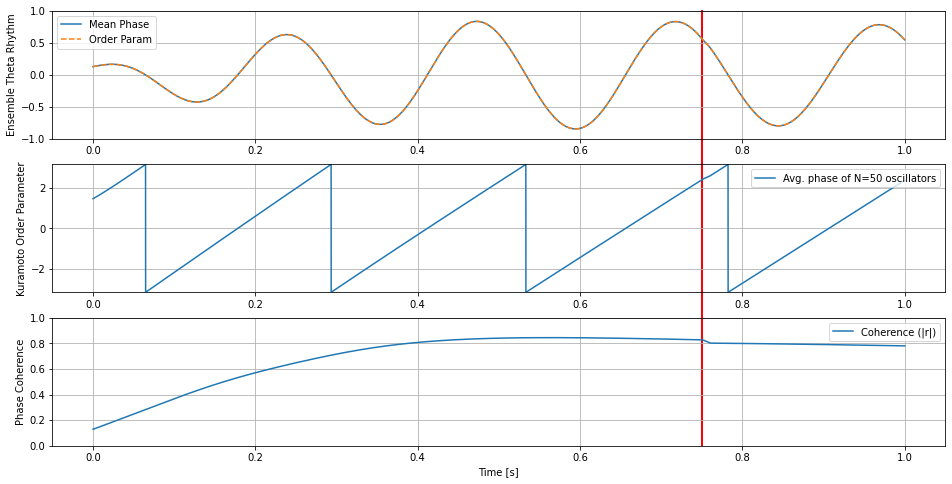

In [5]:
# plot the results
fig, axs = subplots(3,1)
fig.set_figheight(8)
fig.set_figwidth(16)
axs[0].plot(mon_osc.t/second, mean(sin(mon_osc.Theta), axis=0), label='Mean Phase')
#axs[0].plot(mon_avg.t/second, mon_avg.coherence[0]*sin(mon_avg.phase[0]), '--', label='Order Param')
axs[0].plot(mon_avg.t/second, mon_avg.rhythm[0], '--', label='Order Param')
axs[1].plot(mon_avg.t/second, mon_avg.phase[0], '-', label='Avg. phase of N=%d oscillators'%N)
axs[2].plot(mon_avg.t/second, mon_avg.coherence[0], '-', label='Coherence (|r|)')

# labels
axs[0].set_ylabel("Ensemble Theta Rhythm")
axs[1].set_ylabel("Kuramoto Phase")
axs[2].set_ylabel("Order Parameter")
axs[2].set_xlabel("Time [s]")
axs[0].set_ylim([-1,1])
axs[1].set_ylim([-pi,pi])
axs[2].set_ylim([0,1])
axs[0].axvline(x=0.75, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[1].axvline(x=0.75, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=False)
axs[2].axvline(x=0.75, ymin=-1, ymax=1, c="red", linewidth=2, zorder=0, clip_on=True)

# make things pretty
axs[0].legend()
axs[0].grid()
axs[1].legend()
axs[1].grid()
axs[2].legend()
axs[2].grid()

# show
fig.savefig('sample.png', facecolor='white', transparent=False)
show()

# Connect to a spiking HH network template

Now that we have an ensemble theta rhythm, we can use that to drive a population of spiking neurons:

In [6]:
start_scope()

# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
N = 1e3

# The model
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I_ext)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I_ext : amp (linked)
'''

neurons_HH = NeuronGroup(N, eqs_HH, threshold='v > -40*mV', refractory='v > -40*mV', method='exponential_euler')
neurons_HH.v = 'El+10*randn()*mV'

# linked variable I_ext
neurons_HH.I_ext = linked_var(population, 'rhythm_rect')

# add a few monitors
mon_spikes_HH = SpikeMonitor(neurons_HH)
mon_v_HH = StateMonitor(neurons_HH, ['I_ext', 'v'], record=True)

net_kur.add(neurons_HH)
net_kur.add(mon_spikes_HH)
net_kur.add(mon_v_HH)

net_kur.run(500*ms)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "ThetaPreInput_post = Theta_pre"
 [brian2.codegen.generators.base]


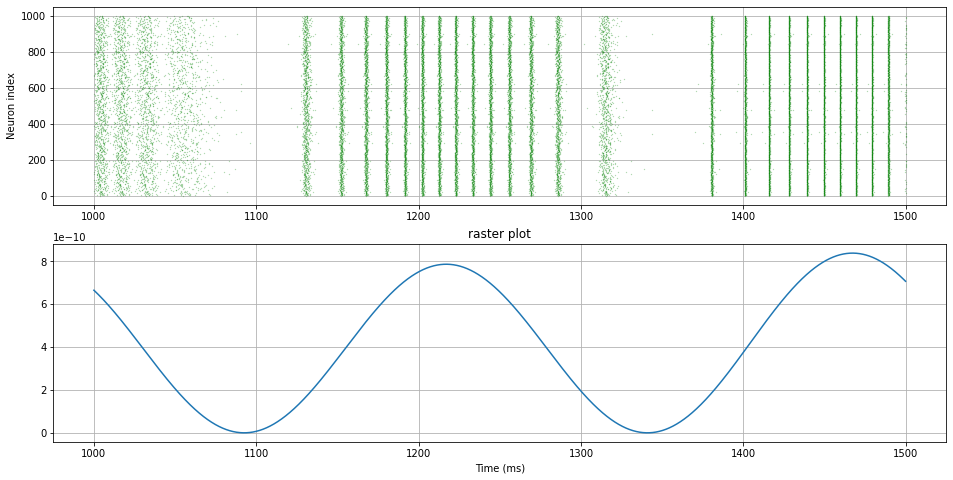

In [7]:
raster_fig, raster_ax = plt.subplots(nrows=2, ncols=1)
raster_fig.set_figheight(8)
raster_fig.set_figwidth(16)

title('raster plot')
raster_ax[0].plot(mon_spikes_HH.t/msecond, mon_spikes_HH.i, '.g', markersize=.5,alpha=0.5)
#raster_ax[0].set_xlim(])
raster_ax[0].set_ylabel('Neuron index')
raster_ax[0].grid()


raster_ax[1].plot(mon_v_HH.t/msecond, mon_v_HH.I_ext[0])
raster_ax[1].set_xlabel('Time (ms)')
#raster_ax[1].set_ylim([-1,1])
raster_ax[1].grid()